# Mounting the google drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Installing vit-keras and tensorflow addons

In [2]:
!pip install vit-keras
!pip install tensorflow-addons

     |████████████████████████████████| 1.1 MB 15.1 MB/s 


# Importing required modules

In [3]:
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
from sklearn.model_selection import RepeatedStratifiedKFold, train_test_split
from vit_keras import vit, utils, visualize

# Loading the data and labels
### Converting the labels to int from float
### Increasing the number of channels to three from one 

In [4]:
images_data = np.load('/content/drive/MyDrive/Datasets/figshare-brain-tumor/brain_tumor_figshare_224.npy')
images_labels = np.load('/content/drive/MyDrive/Datasets/figshare-brain-tumor/brain_tumor_figshare_labels.npy')

# chaning labels from float to int
images_labels = images_labels-1
images_labels = images_labels.astype(int)
print(images_labels)

# increasing the number of channels to three
images_data = 255 * images_data
images_data = np.repeat(images_data[..., np.newaxis], 3, -1)
print(images_data.shape)
print(np.min(images_data))
print(np.max(images_data))  

[0 0 0 ... 2 2 2]
(3064, 224, 224, 3)
0.0
255.0


## Preprocessing the data before feeding it to the CNN model

In [5]:
images_data = tf.keras.applications.efficientnet_v2.preprocess_input(images_data)
print(np.min(images_data))
print(np.max(images_data))

0.0
255.0


## Preprocessing the data before feeding it to vision transformer

In [5]:
images_data = vit.preprocess_inputs(images_data)
print(np.min(images_data))
print(np.max(images_data))

-1.0
1.0


## Splitting the data into training and testing using 'train_test_split' from sklearn 

In [18]:
x_train, x_test, y_train, y_test = train_test_split(images_data, images_labels, test_size = 0.2)

In [ ]:
resolution = 224

In [19]:
if resolution == 224:
  np.save('/content/drive/MyDrive/Datasets/figshare-brain-tumor/x_train_224', x_train)
  np.save('/content/drive/MyDrive/Datasets/figshare-brain-tumor/y_train_224', y_train)
  np.save('/content/drive/MyDrive/Datasets/figshare-brain-tumor/x_test_224', x_test)
  np.save('/content/drive/MyDrive/Datasets/figshare-brain-tumor/y_test_224', y_test)
else:
  np.save('/content/drive/MyDrive/Datasets/figshare-brain-tumor/x_train_384', x_train)
  np.save('/content/drive/MyDrive/Datasets/figshare-brain-tumor/y_train_384', y_train)
  np.save('/content/drive/MyDrive/Datasets/figshare-brain-tumor/x_test_384', x_test)
  np.save('/content/drive/MyDrive/Datasets/figshare-brain-tumor/y_test_384', y_test)

In [ ]:
if resolution == 224:
  x_train = np.load('/content/drive/MyDrive/Datasets/figshare-brain-tumor/x_train_224.npy')
  y_train = np.load('/content/drive/MyDrive/Datasets/figshare-brain-tumor/y_train_224.npy')
  x_test = np.load('/content/drive/MyDrive/Datasets/figshare-brain-tumor/x_test_224.npy')
  y_test = np.load('/content/drive/MyDrive/Datasets/figshare-brain-tumor/y_test_224.npy')
else:
  x_train = np.load('/content/drive/MyDrive/Datasets/figshare-brain-tumor/x_train_384.npy')
  y_train = np.load('/content/drive/MyDrive/Datasets/figshare-brain-tumor/y_train_384.npy')
  x_test = np.load('/content/drive/MyDrive/Datasets/figshare-brain-tumor/x_test_384.npy')
  y_test = np.load('/content/drive/MyDrive/Datasets/figshare-brain-tumor/y_test_384.npy')

## Alternative to train_test_split

In [ ]:
folds = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 1)

for train_index, test_index in folds.split(images_data, images_labels):
    images_data_cv, images_data_test, images_labels_cv, images_labels_test = images_data[train_index], images_data[test_index], images_labels[train_index], images_labels[test_index]

print(f'input size for cross-validation is {len(images_labels_cv)}')

print(f'input size for testing is {len(images_labels_test)}')

input size for cross-validation is 2452
input size for testing is 612


## Load a pretrained CNN model

In [87]:
img_shape = (images_data.shape[1], images_data.shape[2], 3)

base_model = tf.keras.applications.EfficientNetV2B3(include_top = False, input_shape = img_shape, weights = 'imagenet')

model = tf.keras.Sequential()
#model.add(tf.keras.layers.Conv2D(3, (3,3), padding = 'same', activation = 'relu', input_shape = (images_data.shape[1], images_data.shape[2], 1)))
#model.add(tf.keras.layers.BatchNormalization())
model.add(base_model)
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(tf.keras.layers.Dense(3, activation = 'softmax'))

In [88]:
base_model.trainable = True
    
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))
    
# Fine-tune from this layer onwards
fine_tune_at = int(0.8 * len(base_model.layers))
    
# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False
    
model.compile(optimizer = tf.keras.optimizers.Adadelta(learning_rate = 1.0), loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
model.summary()

Number of layers in the base model:  383
Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-b3 (Function  (None, 7, 7, 1536)       12930622  
 al)                                                             
                                                                 
 global_average_pooling2d_13  (None, 1536)             0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_13 (Dense)            (None, 3)                 4611      
                                                                 
Total params: 12,935,233
Trainable params: 4,824,293
Non-trainable params: 8,110,940
_________________________________________________________________


## Training and validating the CNN model

In [89]:
model.fit(x_train, y_train, batch_size = 32, epochs = 15, validation_split = 0.15)

Epoch 1/15
66/66 [==============================] - 16s 118ms/step - loss: 0.3463 - accuracy: 0.8608 - val_loss: 0.2817 - val_accuracy: 0.8913
Epoch 2/15
66/66 [==============================] - 5s 82ms/step - loss: 0.0754 - accuracy: 0.9755 - val_loss: 0.1205 - val_accuracy: 0.9538
Epoch 3/15
66/66 [==============================] - 5s 83ms/step - loss: 0.0303 - accuracy: 0.9899 - val_loss: 0.2602 - val_accuracy: 0.9158
Epoch 4/15
66/66 [==============================] - 5s 82ms/step - loss: 0.0152 - accuracy: 0.9942 - val_loss: 0.1012 - val_accuracy: 0.9647
Epoch 5/15
66/66 [==============================] - 5s 82ms/step - loss: 0.0045 - accuracy: 0.9990 - val_loss: 0.1485 - val_accuracy: 0.9620
Epoch 6/15
66/66 [==============================] - 5s 83ms/step - loss: 0.0039 - accuracy: 0.9986 - val_loss: 0.4609 - val_accuracy: 0.8967
Epoch 7/15
66/66 [==============================] - 5s 82ms/step - loss: 0.0110 - accuracy: 0.9962 - val_loss: 0.3650 - val_accuracy: 0.9130
Epoch 8/15


## Testing the CNN model

In [90]:
model.evaluate(x_test, y_test)

20/20 [==============================] - 1s 54ms/step - loss: 0.1599 - accuracy: 0.9543


[0.15985330939292908, 0.9543229937553406]

In [84]:
y_pred = model.predict(x_test)

In [85]:
print(y_pred)
y_prob = np.argmax(y_pred, axis = 1) # softmax outputs converted to labels
print(y_prob)

[[9.99984741e-01 1.52374705e-05 2.48289087e-08]
 [4.38394591e-06 2.05651372e-06 9.99993563e-01]
 [9.71860290e-01 2.73488164e-02 7.90995080e-04]
 ...
 [3.20388699e-06 6.16145235e-06 9.99990582e-01]
 [8.21610229e-08 9.99999881e-01 3.64160613e-08]
 [5.75369841e-09 3.78113363e-09 1.00000000e+00]]
[0 2 0 1 1 0 1 1 0 2 2 1 1 0 2 0 0 1 1 0 2 1 2 1 2 2 1 2 0 1 2 1 2 1 1 0 0
 1 1 1 1 2 1 1 0 1 1 1 1 2 1 1 1 1 1 2 2 2 1 2 2 2 2 0 1 2 1 0 0 1 2 1 2 1
 1 2 1 0 2 1 1 0 1 0 1 1 2 2 0 1 1 1 1 0 1 1 2 1 1 1 1 2 0 2 2 2 0 1 1 0 1
 2 1 1 1 1 1 2 1 1 2 0 2 0 1 1 1 0 1 0 0 1 2 0 1 2 2 1 1 2 1 1 1 0 2 1 0 1
 2 1 2 1 1 1 2 1 1 2 2 1 1 0 2 2 1 2 0 1 2 1 1 2 0 2 0 2 2 1 1 1 2 1 1 0 2
 0 0 2 1 1 0 1 2 1 1 1 2 1 1 0 1 0 0 2 0 0 2 1 0 0 2 0 0 1 0 2 2 1 2 1 0 1
 0 0 1 1 0 1 2 1 2 0 2 2 1 1 1 1 0 1 2 0 1 2 0 2 0 0 1 2 1 1 1 1 2 1 1 1 2
 1 2 2 2 1 0 1 1 2 1 1 1 1 0 1 2 1 1 1 1 1 1 2 2 1 0 2 1 2 1 1 1 1 1 1 1 2
 1 1 1 1 1 1 0 2 1 2 1 1 1 1 1 1 2 1 1 2 0 2 2 2 1 0 1 1 2 1 0 0 2 0 0 2 1
 2 1 0 2 2 1 2 2 1 2 0 2 0 0 0 

In [45]:
import tensorflow_addons as tfa
metric = tfa.metrics.F1Score(num_classes=3, threshold=0.5)
metric.update_state(tf.keras.utils.to_categorical(y_test), tf.keras.utils.to_categorical(y_prob))
result = metric.result()
result.numpy()

array([0.9230769, 0.9722222, 0.9846154], dtype=float32)

## Loaind the pretrained vision transformer model from vit-keras

In [10]:
image_size = images_data.shape[1]
vit_base_model = vit.vit_b32(include_top = False, pretrained_top = False, activation = 'softmax', pretrained = True, classes = 3, image_size = image_size)

vit_model = tf.keras.Sequential()
vit_model.add(vit_base_model)
vit_model.add(tf.keras.layers.Flatten())
vit_model.add(tf.keras.layers.BatchNormalization())
vit_model.add(tf.keras.layers.Dense(10, activation = 'gelu'))
vit_model.add(tf.keras.layers.BatchNormalization())
vit_model.add(tf.keras.layers.Dense(3, activation = 'softmax'))

/usr/local/lib/python3.7/dist-packages/vit_keras/utils.py:83: UserWarning: Resizing position embeddings from 12, 12 to 7, 7
  UserWarning,


## Model compilation and summary

In [11]:
vit_model.compile(optimizer = tf.keras.optimizers.Adadelta(learning_rate = 0.01), loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
vit_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vit-b32 (Functional)        (None, 768)               87455232  
                                                                 
 flatten_1 (Flatten)         (None, 768)               0         
                                                                 
 batch_normalization_2 (Batc  (None, 768)              3072      
 hNormalization)                                                 
                                                                 
 dense_2 (Dense)             (None, 10)                7690      
                                                                 
 batch_normalization_3 (Batc  (None, 10)               40        
 hNormalization)                                                 
                                                                 
 dense_3 (Dense)             (None, 3)                

## Training and validating the model

In [12]:
vit_model.fit(x_train, y_train, batch_size = 16, epochs = 40, validation_split = 0.15)

Epoch 1/40
82/82 [==============================] - 33s 242ms/step - loss: 0.9635 - accuracy: 0.5707 - val_loss: 0.7972 - val_accuracy: 0.6565
Epoch 2/40
82/82 [==============================] - 17s 210ms/step - loss: 0.5547 - accuracy: 0.7811 - val_loss: 0.5184 - val_accuracy: 0.7913
Epoch 3/40
82/82 [==============================] - 17s 206ms/step - loss: 0.4931 - accuracy: 0.8210 - val_loss: 0.4412 - val_accuracy: 0.7913
Epoch 4/40
82/82 [==============================] - 17s 204ms/step - loss: 0.4411 - accuracy: 0.8303 - val_loss: 0.3591 - val_accuracy: 0.8652
Epoch 5/40
82/82 [==============================] - 17s 204ms/step - loss: 0.3767 - accuracy: 0.8717 - val_loss: 0.3250 - val_accuracy: 0.8957
Epoch 6/40
82/82 [==============================] - 17s 206ms/step - loss: 0.3324 - accuracy: 0.8856 - val_loss: 0.3159 - val_accuracy: 0.8739
Epoch 7/40
82/82 [==============================] - 17s 206ms/step - loss: 0.2942 - accuracy: 0.9071 - val_loss: 0.2767 - val_accuracy: 0.8870

## Model testing on the test set

In [13]:
vit_model.evaluate(x_test, y_test)

48/48 [==============================] - 6s 115ms/step - loss: 0.1874 - accuracy: 0.9413


[0.18737761676311493, 0.9412532448768616]

In [14]:
y_pred = vit_model.predict(x_test)

In [15]:
print(y_pred)
y_prob = np.argmax(y_pred, axis = 1) # softmax outputs converted to labels
print(y_prob)

[[8.0867745e-03 9.8414534e-01 7.7678314e-03]
 [2.8646067e-01 6.7482167e-01 3.8717616e-02]
 [2.7132029e-02 2.1521060e-04 9.7265279e-01]
 ...
 [1.3332987e-01 8.4590381e-01 2.0766249e-02]
 [2.9620139e-03 1.6979919e-03 9.9533999e-01]
 [9.4987679e-01 1.7379193e-02 3.2744020e-02]]
[1 1 2 ... 1 2 0]


In [17]:
from sklearn.metrics import roc_auc_score
y_test = tf.keras.utils.to_categorical(y_test)
y_prob = tf.keras.utils.to_categorical(y_prob)
macro_roc_auc_ovo = roc_auc_score(y_test, y_prob, multi_class="ovo", average="macro")
weighted_roc_auc_ovo = roc_auc_score(
    y_test, y_prob, multi_class="ovo", average="weighted"
)
macro_roc_auc_ovr = roc_auc_score(y_test, y_prob, multi_class="ovr", average="macro")
weighted_roc_auc_ovr = roc_auc_score(
    y_test, y_prob, multi_class="ovr", average="weighted"
)
print(
    "One-vs-One ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
    "(weighted by prevalence)".format(macro_roc_auc_ovo, weighted_roc_auc_ovo)
)
print(
    "One-vs-Rest ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
    "(weighted by prevalence)".format(macro_roc_auc_ovr, weighted_roc_auc_ovr)
)

One-vs-One ROC AUC scores:
0.950251 (macro),
0.955345 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.950251 (macro),
0.955345 (weighted by prevalence)


[[293  26  31]
 [ 28 693   4]
 [  1   0 456]]


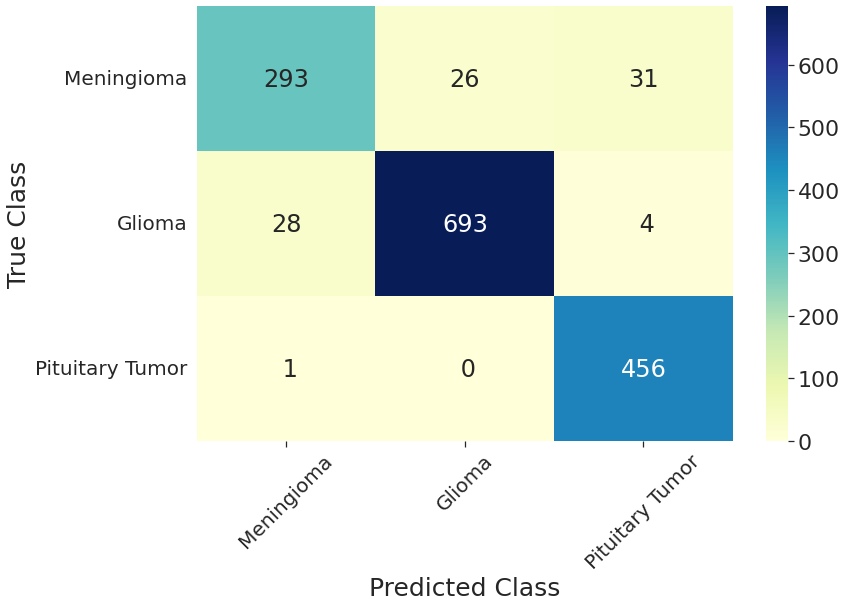

In [16]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

confusion_mat = confusion_matrix(y_test, y_prob, normalize = None)
class_names = ['Meningioma', 'Glioma', 'Pituitary Tumor']
print(confusion_mat)

# Plotting multilabel confusion matrix in a beautiful manner
sns.set(font_scale=2)
fig = plt.figure(figsize=(12, 8))
ax= plt.subplot()
sns.heatmap(confusion_mat, annot=True, vmin = 0, vmax = np.max(confusion_mat), ax = ax, cmap = 'YlGnBu', fmt = '2.0f'); #annot=True to annotate cells
# labels, title and ticks
ax.set_xlabel('Predicted Class', fontsize=25)
ax.xaxis.set_label_position('bottom')
plt.xticks(rotation=45)
ax.xaxis.set_ticklabels(class_names, fontsize = 20)
ax.xaxis.tick_bottom()

ax.set_ylabel('True Class', fontsize=25)
ax.yaxis.set_ticklabels(class_names, fontsize = 20)
plt.yticks(rotation=0)

#plt.title('Confusion Matrix 224', fontsize=25)

plt.show()

In [ ]:
image = x_test[0]
print(image.shape)

attention_map = visualize.attention_map(model = vit_model, image = image)

# Plot results
fig, (ax1, ax2) = plt.subplots(ncols = 2)
ax1.axis('off')
ax2.axis('off')
ax1.set_title('Original')
ax2.set_title('Attention Map')
_ = ax1.imshow(image)
_ = ax2.imshow(attention_map)
